In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

## Cognitive Load Info

In [2]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [3]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [4]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
) 
for file in tqdm(acc_data_paths, desc="Loading ACC data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    acc_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

Loading ACC data:   0%|          | 0/68 [00:00<?, ?it/s]

270

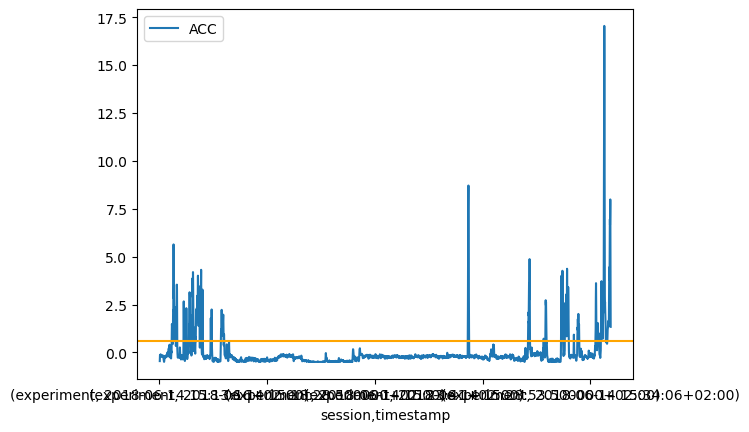

In [6]:
import matplotlib.pyplot as plt
physiological_data['ACC']['left']['s037'].plot()
plt.axhline(physiological_data['ACC']['left']['s037'].quantile(0.90)[0], color='orange')
plt.show()

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [7]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [8]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [8]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [10]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [11]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [12]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [13]:
eda_data = physiological_data['EDA']

In [14]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [15]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


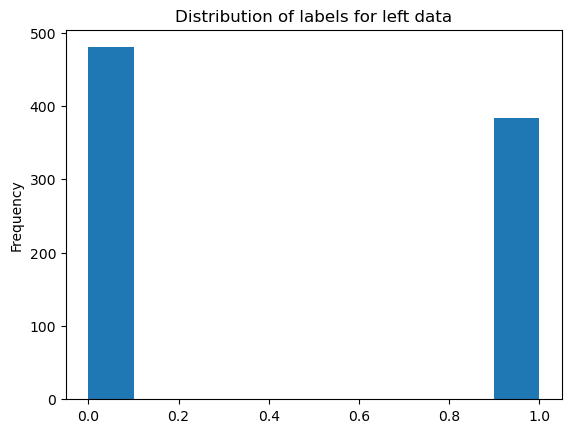

In [18]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


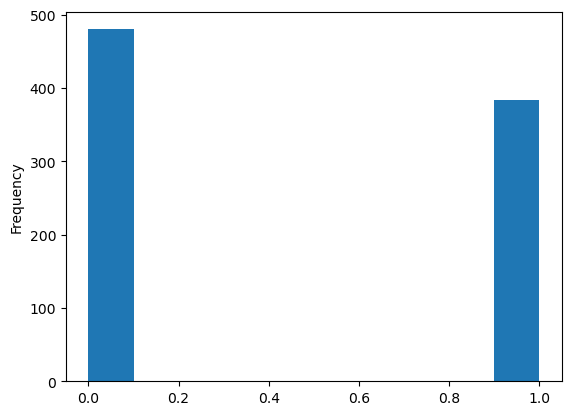

In [19]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [20]:
from sys import path
path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_left))
features_right = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_right))

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Coul

In [21]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


## ML Prediction

In [58]:
from typing import Callable
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)

def resampling(df: DataFrame, resampling_method: BaseUnderSampler = RandomUnderSampler, random_state: int = 42) -> DataFrame:
    x = df.drop(columns=["label"], inplace=False).values
    y = df["label"].values
    cc = resampling_method(random_state=random_state)
    x_resampled, y_resampled = cc.fit_resample(x, y)
    result = DataFrame(x_resampled)
    result['label'] = y_resampled
    return result

### 5-fold CV

In [39]:
from sklearn.model_selection import KFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
def run_cv_ml(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values


    folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    return pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

#### LX v LX

In [40]:
run_cv_ml(features_left, labels_left, groups_left)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.46it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier              0.78              0.78    0.78     0.78   
RandomForestClassifier            0.77              0.77    0.77     0.77   
LGBMClassifier                    0.76              0.76    0.76     0.76   
XGBClassifier                     0.76              0.76    0.76     0.76   
BaggingClassifier                 0.76              0.75    0.75     0.75   
KNeighborsClassifier              0.73              0.73    0.73     0.73   
LabelPropagation                  0.72              0.72    0.72     0.72   
LabelSpreading                    0.72              0.72    0.72     0.72   
DecisionTreeClassifier            0.71              0.71    0.71     0.71   
AdaBoostClassifier                0.71              0.71    0.71     0.71   
NuSVC                             0.70              0.70    0.70     0.70   
SVC                               0.70              0.70    0.70     0.70   
ExtraTreeClassifier               0.69              0.69    0.69     0.69   
RidgeClassifierCV                 0.64              0.64    0.64     0.64   
RidgeClassifier                   0.64              0.64    0.64     0.64   
LinearDiscriminantAnalysis        0.63              0.63    0.63     0.63   
CalibratedClassifierCV            0.63              0.63    0.63     0.63   
LogisticRegression                0.63              0.63    0.63     0.63   
LinearSVC                         0.63              0.63    0.63     0.63   
NearestCentroid                   0.62              0.62    0.62     0.62   
BernoulliNB                       0.62              0.62    0.62     0.62   
SGDClassifier                     0.57              0.57    0.57     0.56   
Perceptron                        0.56              0.56    0.56     0.55   
GaussianNB                        0.55              0.55    0.55     0.47   
QuadraticDiscriminantAnalysis     0.52              0.53    0.53     0.47   
PassiveAggressiveClassifier       0.48              0.49    0.49     0.43   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier                0.07           0.01              0.01   
RandomForestClassifier              0.11           0.01              0.01   
LGBMClassifier                      0.30           0.01              0.01   
XGBClassifier                       0.48           0.01              0.01   
BaggingClassifier                   0.03           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
LabelPropagation                    0.01           0.00              0.01   
LabelSpreading                      0.01           0.01              0.01   
DecisionTreeClassifier              0.01           0.02              0.02   
AdaBoostClassifier                  0.06           0.01              0.01   
NuSVC                               0.02           0.01              0.01   
SVC                                 0.01           0.01              0.01   
ExtraTreeClassifier                 0.00           0.02              0.02   
RidgeClassifierCV                   0.00           0.02              0.02   
RidgeClassifier                     0.01           0.02              0.02   
LinearDiscriminantAnalysis          0.00           0.02              0.02   
CalibratedClassifierCV              0.11           0.02              0.02   
LogisticRegression                  0.01           0.02              0.02   
LinearSVC                           0.03           0.02              0.02   
NearestCentroid           

#### RX vs RX

In [41]:
run_cv_ml(features_right, labels_right, groups_right)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 20.95it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.82              0.82    0.82     0.82   
LGBMClassifier                    0.82              0.82    0.82     0.82   
BaggingClassifier                 0.82              0.81    0.81     0.81   
XGBClassifier                     0.81              0.81    0.81     0.81   
ExtraTreesClassifier              0.81              0.81    0.81     0.81   
KNeighborsClassifier              0.79              0.79    0.79     0.79   
AdaBoostClassifier                0.77              0.77    0.77     0.77   
LabelSpreading                    0.77              0.77    0.77     0.77   
LabelPropagation                  0.77              0.77    0.77     0.77   
NuSVC                             0.77              0.77    0.77     0.77   
SVC                               0.76              0.76    0.76     0.76   
DecisionTreeClassifier            0.75              0.75    0.75     0.75   
ExtraTreeClassifier               0.74              0.73    0.73     0.74   
BernoulliNB                       0.71              0.71    0.71     0.71   
NearestCentroid                   0.71              0.70    0.70     0.70   
CalibratedClassifierCV            0.70              0.70    0.70     0.70   
GaussianNB                        0.70              0.70    0.70     0.70   
LinearDiscriminantAnalysis        0.69              0.69    0.69     0.69   
RidgeClassifierCV                 0.69              0.69    0.69     0.69   
LinearSVC                         0.69              0.69    0.69     0.69   
LogisticRegression                0.69              0.69    0.69     0.69   
RidgeClassifier                   0.69              0.69    0.69     0.69   
SGDClassifier                     0.62              0.62    0.62     0.62   
QuadraticDiscriminantAnalysis     0.60              0.59    0.59     0.57   
PassiveAggressiveClassifier       0.58              0.58    0.58     0.56   
Perceptron                        0.56              0.56    0.56     0.55   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.10           0.01              0.01   
LGBMClassifier                      0.31           0.01              0.01   
BaggingClassifier                   0.02           0.01              0.01   
XGBClassifier                       0.46           0.02              0.02   
ExtraTreesClassifier                0.07           0.02              0.02   
KNeighborsClassifier                0.01           0.02              0.02   
AdaBoostClassifier                  0.06           0.01              0.01   
LabelSpreading                      0.02           0.01              0.01   
LabelPropagation                    0.01           0.01              0.01   
NuSVC                               0.01           0.01              0.01   
SVC                                 0.01           0.01              0.01   
DecisionTreeClassifier              0.01           0.01              0.02   
ExtraTreeClassifier                 0.00           0.02              0.02   
BernoulliNB                         0.00           0.00              0.00   
NearestCentroid                     0.00           0.01              0.01   
CalibratedClassifierCV              0.11           0.01              0.01   
GaussianNB                          0.00           0.02              0.02   
LinearDiscriminantAnalysis          0.00           0.01              0.01   
RidgeClassifierCV                   0.00           0.01              0.01   
LinearSVC                 

#### LX vs RX

In [42]:
def local_resampling(x, y, groups, resampling_method: BaseUnderSampler = RandomUnderSampler):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values
    return x_resampled, y_resampled, groups

In [45]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.77,0.77,0.77,0.77,0.12
SVC,0.76,0.76,0.76,0.76,0.03
KNeighborsClassifier,0.76,0.76,0.76,0.75,0.01
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.08
AdaBoostClassifier,0.74,0.74,0.74,0.74,0.06
LGBMClassifier,0.73,0.73,0.73,0.73,0.38
LabelSpreading,0.73,0.73,0.73,0.73,0.02
NuSVC,0.73,0.73,0.73,0.73,0.03
LabelPropagation,0.73,0.73,0.73,0.73,0.01


#### RX vs LX

In [46]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 20.31it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.01
RandomForestClassifier,0.71,0.71,0.71,0.71,0.12
BaggingClassifier,0.71,0.71,0.71,0.71,0.03
LabelPropagation,0.71,0.71,0.71,0.71,0.02
LabelSpreading,0.71,0.71,0.71,0.71,0.02
ExtraTreesClassifier,0.70,0.70,0.70,0.70,0.08
LGBMClassifier,0.70,0.70,0.70,0.70,0.36
XGBClassifier,0.70,0.70,0.70,0.70,0.45
NuSVC,0.70,0.70,0.70,0.70,0.03


## 5-fold CV - different seeds

In [49]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed


def run_cv_ml_multiple_seeds(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 10
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    set_numpy_seed(666)
    n_seeds_to_test_folds: int = 10
    random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

    for random_state_folds in tqdm(
        random_states_folds, desc="Random states folds progress:", colour="blue"
    ):
        for random_state_classifier in tqdm(
            random_states_classifiers,
            desc="Random states classifiers progress:",
            colour="green",
        ):
            # NOTE: the fold generation should be fixed, to limit the accuracy
            # be due exclusively to starting confitions in the algorithm
            folds = StratifiedKFold(
                n_splits=5, random_state=random_state_folds, shuffle=True
            ).split(x_resampled, y_resampled)
            # TODO: we should iterate over different random states for the fold
            # generation as well, but independent from the random seeds for the algorithm
            # all_models = []
            # for train_index, test_index in folds:
            #     x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            #     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            #     clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            #     models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            #     all_models.append(models)
            from joblib import Parallel, delayed

            def run_fold(train_index, test_index):
                x_train, x_test = x_resampled[train_index], x_resampled[test_index]
                y_train, y_test = y_resampled[train_index], y_resampled[test_index]
                clf = LazyClassifier(
                    predictions=True, random_state=random_state_classifier
                )
                models, predictions = clf.fit(x_train, x_test, y_train, y_test)
                return models

            all_models = Parallel(n_jobs=-1)(
                delayed(run_fold)(train_index, test_index)
                for train_index, test_index in folds
            )

            averages = (
                pd.concat(all_models)
                .groupby(level=0)
                .mean()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_deviations = (
                pd.concat(all_models)
                .groupby(level=0)
                .std()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_errors = standard_deviations / 5**0.5
            results.append(
                pd.concat(
                    [averages, standard_errors],
                    axis=1,
                    keys=["Average", "Standard error"],
                )
            )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [51]:
result = run_cv_ml_multiple_seeds(features_left, labels_left, groups_left)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 44.28it/s]

100%|██████████| 29/29 [00:00<00:00, 46.14it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.34it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.26it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.17it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.30it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]



Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.12it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.71it/s]


In [53]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7653            0.7652  0.7652   0.7648   
RandomForestClassifier          0.7592            0.7591  0.7591   0.7587   
LGBMClassifier                  0.7504            0.7504  0.7504   0.7500   
XGBClassifier                   0.7410            0.7410  0.7410   0.7405   
BaggingClassifier               0.7401            0.7401  0.7401   0.7395   
AdaBoostClassifier              0.7192            0.7192  0.7192   0.7185   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
LabelPropagation                0.7178            0.7178  0.7178   0.7173   
KNeighborsClassifier            0.7177            0.7177  0.7177   0.7173   
NuSVC                           0.7101            0.7101  0.7101   0.7093   
DecisionTreeClassifier          0.7074            0.7074  0.7074   0.7069   
SVC                             0.6958            0.6958  0.6958   0.6953   
ExtraTreeClassifier             0.6867            0.6867  0.6867   0.6862   
LogisticRegression              0.6376            0.6376  0.6376   0.6369   
CalibratedClassifierCV          0.6373            0.6373  0.6373   0.6367   
RidgeClassifierCV               0.6345            0.6344  0.6344   0.6338   
LinearSVC                       0.6324            0.6324  0.6324   0.6317   
RidgeClassifier                 0.6299            0.6299  0.6299   0.6293   
LinearDiscriminantAnalysis      0.6271            0.6270  0.6270   0.6264   
NearestCentroid                 0.6253            0.6253  0.6253   0.6246   
BernoulliNB                     0.6216            0.6216  0.6216   0.6198   
SGDClassifier                   0.5810            0.5810  0.5810   0.5656   
Perceptron                      0.5598            0.5598  0.5598   0.5439   
PassiveAggressiveClassifier     0.5592            0.5591  0.5591   0.5314   
GaussianNB                      0.5463            0.5463  0.5463   0.4666   
QuadraticDiscriminantAnalysis   0.5392            0.5393  0.5393   0.4784   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0742         0.0014            0.0014   
RandomForestClassifier            0.1099         0.0013            0.0013   
LGBMClassifier                    0.0346         0.0012            0.0012   
XGBClassifier                     0.0733         0.0013            0.0013   
BaggingClassifier                 0.0265         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0018            0.0018   
LabelSpreading                    0.0099         0.0014            0.0014   
LabelPropagation                  0.0076         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
NuSVC                             0.0164         0.0012            0.0012   
DecisionTreeClassifier            0.0064         0.0017            0.0017   
SVC                               0.0130         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0018            0.0018   
LogisticRegression                0.0063         0.0020            0.0020   
CalibratedClassifierCV            0.1115         0.0021            0.0021   
RidgeClassifierCV                 0.0045         0.0019            0.0019   
LinearSVC                         0.0296         0.0019            0.0019   
RidgeClassifier                   0.0044         0.0019            0.0019   
LinearDiscriminantAnalysis        0.0043         0.0019            0.0019   
NearestCentroid           

### RX vs RX

In [54]:
result = run_cv_ml_multiple_seeds(features_right, labels_right, groups_right)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.33it/s]

100%|██████████| 29/29 [00:00<00:00, 46.41it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.33it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.02it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.11it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.57it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.07it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.05it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.34it/s]

100%|██████████| 29/29 [00:00<00:00, 43.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.06it/s]


In [55]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8144            0.8144  0.8144   0.8141   
RandomForestClassifier          0.8134            0.8134  0.8134   0.8132   
LGBMClassifier                  0.8083            0.8083  0.8083   0.8081   
XGBClassifier                   0.8064            0.8064  0.8064   0.8062   
BaggingClassifier               0.7993            0.7993  0.7993   0.7989   
KNeighborsClassifier            0.7829            0.7829  0.7829   0.7827   
AdaBoostClassifier              0.7738            0.7738  0.7738   0.7735   
NuSVC                           0.7703            0.7703  0.7703   0.7699   
SVC                             0.7663            0.7663  0.7663   0.7659   
DecisionTreeClassifier          0.7624            0.7624  0.7624   0.7620   
LabelSpreading                  0.7592            0.7593  0.7593   0.7587   
LabelPropagation                0.7569            0.7569  0.7569   0.7564   
ExtraTreeClassifier             0.7427            0.7427  0.7427   0.7423   
CalibratedClassifierCV          0.7047            0.7047  0.7047   0.7040   
NearestCentroid                 0.7010            0.7010  0.7010   0.7004   
BernoulliNB                     0.6989            0.6989  0.6989   0.6982   
LinearDiscriminantAnalysis      0.6966            0.6966  0.6966   0.6961   
GaussianNB                      0.6961            0.6960  0.6960   0.6934   
LinearSVC                       0.6915            0.6914  0.6914   0.6908   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6908   
LogisticRegression              0.6914            0.6914  0.6914   0.6908   
RidgeClassifier                 0.6907            0.6907  0.6907   0.6901   
SGDClassifier                   0.6372            0.6372  0.6372   0.6294   
Perceptron                      0.6114            0.6114  0.6114   0.6019   
PassiveAggressiveClassifier     0.6103            0.6103  0.6103   0.5937   
QuadraticDiscriminantAnalysis   0.6078            0.6078  0.6078   0.5834   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0710         0.0012            0.0012   
RandomForestClassifier            0.1069         0.0014            0.0014   
LGBMClassifier                    0.0358         0.0014            0.0014   
XGBClassifier                     0.0702         0.0013            0.0013   
BaggingClassifier                 0.0258         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0013            0.0013   
NuSVC                             0.0127         0.0017            0.0017   
SVC                               0.0113         0.0016            0.0016   
DecisionTreeClassifier            0.0065         0.0015            0.0015   
LabelSpreading                    0.0102         0.0015            0.0015   
LabelPropagation                  0.0077         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0017            0.0017   
CalibratedClassifierCV            0.1130         0.0017            0.0017   
NearestCentroid                   0.0040         0.0017            0.0017   
BernoulliNB                       0.0040         0.0017            0.0017   
LinearDiscriminantAnalysis        0.0043         0.0016            0.0016   
GaussianNB                        0.0039         0.0021            0.0021   
LinearSVC                         0.0296         0.0016            0.0016   
RidgeClassifierCV         

## LOSO

### Support

In [56]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [62]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
    
def run_same_side_classifications(x, y, folds):
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = RandomUnderSampler(random_state=42)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    # del x_with_folds_resampled
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [63]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method, random_state=random_state)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = resampling_method(random_state=random_state)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [64]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 40.70it/s]


In [65]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
NuSVC                           0.6628            0.6628  0.6628   0.6352   
ExtraTreesClassifier            0.6607            0.6607  0.6607   0.6334   
KNeighborsClassifier            0.6562            0.6562  0.6562   0.6323   
SVC                             0.6549            0.6549  0.6549   0.6238   
RandomForestClassifier          0.6424            0.6424  0.6424   0.6106   
LabelPropagation                0.6419            0.6419  0.6419   0.6221   
LabelSpreading                  0.6367            0.6367  0.6367   0.6156   
CalibratedClassifierCV          0.6341            0.6341  0.6341   0.6095   
LogisticRegression              0.6302            0.6302  0.6302   0.6057   
RidgeClassifierCV               0.6289            0.6289  0.6289   0.6038   
RidgeClassifier                 0.6289            0.6289  0.6289   0.6046   
BaggingClassifier               0.6254            0.6254  0.6254   0.6032   
LinearSVC                       0.6249            0.6249  0.6249   0.6009   
LGBMClassifier                  0.6237            0.6237  0.6237   0.5954   
AdaBoostClassifier              0.6226            0.6226  0.6226   0.5937   
LinearDiscriminantAnalysis      0.6185            0.6185  0.6185   0.5905   
NearestCentroid                 0.6172            0.6172  0.6172   0.5900   
XGBClassifier                   0.6094            0.6094  0.6094   0.5801   
BernoulliNB                     0.6016            0.6016  0.6016   0.5734   
DecisionTreeClassifier          0.5930            0.5930  0.5930   0.5735   
ExtraTreeClassifier             0.5929            0.5929  0.5929   0.5753   
SGDClassifier                   0.5667            0.5667  0.5667   0.5238   
Perceptron                      0.5499            0.5499  0.5499   0.5077   
GaussianNB                      0.5456            0.5456  0.5456   0.4270   
QuadraticDiscriminantAnalysis   0.5365            0.5365  0.5365   0.4446   
PassiveAggressiveClassifier     0.5360            0.5360  0.5360   0.4809   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
NuSVC                             0.0243         0.0185            0.0185   
ExtraTreesClassifier              0.1010         0.0173            0.0173   
KNeighborsClassifier              0.0054         0.0161            0.0161   
SVC                               0.0174         0.0216            0.0216   
RandomForestClassifier            0.1519         0.0181            0.0181   
LabelPropagation                  0.0107         0.0162            0.0162   
LabelSpreading                    0.0146         0.0169            0.0169   
CalibratedClassifierCV            0.1643         0.0286            0.0286   
LogisticRegression                0.0088         0.0283            0.0283   
RidgeClassifierCV                 0.0056         0.0290            0.0290   
RidgeClassifier                   0.0054         0.0289            0.0289   
BaggingClassifier                 0.0378         0.0167            0.0167   
LinearSVC                         0.0441         0.0287            0.0287   
LGBMClassifier                    0.0500         0.0184            0.0184   
AdaBoostClassifier                0.0741         0.0178            0.0178   
LinearDiscriminantAnalysis        0.0054         0.0281            0.0281   
NearestCentroid                   0.0057         0.0288            0.0288   
XGBClassifier                     0.1058         0.0177            0.0177   
BernoulliNB                       0.0048         0.0260            0.0260   
DecisionTreeClassifier    

### Test with different seeds (RX vs RX)

In [66]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 37.76it/s]

100%|██████████| 29/29 [00:00<00:00, 34.12it/s]

100%|██████████| 29/29 [00:00<00:00, 32.84it/s]

100%|██████████| 29/29 [00:00<00:00, 41.78it/s]


In [67]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7526            0.7526  0.7526   0.7335   
XGBClassifier                   0.7422            0.7422  0.7422   0.7284   
LGBMClassifier                  0.7396            0.7396  0.7396   0.7236   
ExtraTreesClassifier            0.7393            0.7393  0.7393   0.7230   
KNeighborsClassifier            0.7370            0.7370  0.7370   0.7243   
BaggingClassifier               0.7291            0.7291  0.7291   0.7145   
NuSVC                           0.7279            0.7279  0.7279   0.7042   
SVC                             0.7240            0.7240  0.7240   0.6974   
AdaBoostClassifier              0.7109            0.7109  0.7109   0.6917   
CalibratedClassifierCV          0.7057            0.7057  0.7057   0.6894   
DecisionTreeClassifier          0.7019            0.7019  0.7019   0.6883   
BernoulliNB                     0.6953            0.6953  0.6953   0.6790   
NearestCentroid                 0.6953            0.6953  0.6953   0.6814   
LinearDiscriminantAnalysis      0.6940            0.6940  0.6940   0.6775   
LogisticRegression              0.6888            0.6888  0.6888   0.6721   
LinearSVC                       0.6881            0.6881  0.6881   0.6712   
LabelSpreading                  0.6875            0.6875  0.6875   0.6747   
RidgeClassifierCV               0.6875            0.6875  0.6875   0.6722   
RidgeClassifier                 0.6875            0.6875  0.6875   0.6722   
LabelPropagation                0.6849            0.6849  0.6849   0.6719   
GaussianNB                      0.6784            0.6784  0.6784   0.6658   
ExtraTreeClassifier             0.6775            0.6775  0.6775   0.6665   
SGDClassifier                   0.6280            0.6280  0.6280   0.5956   
PassiveAggressiveClassifier     0.5925            0.5925  0.5925   0.5515   
QuadraticDiscriminantAnalysis   0.5911            0.5911  0.5911   0.5321   
Perceptron                      0.5838            0.5838  0.5838   0.5514   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1466         0.0158            0.0158   
XGBClassifier                     0.1014         0.0139            0.0139   
LGBMClassifier                    0.0507         0.0144            0.0144   
ExtraTreesClassifier              0.0931         0.0149            0.0149   
KNeighborsClassifier              0.0054         0.0154            0.0154   
BaggingClassifier                 0.0363         0.0163            0.0163   
NuSVC                             0.0175         0.0185            0.0185   
SVC                               0.0144         0.0191            0.0191   
AdaBoostClassifier                0.0723         0.0175            0.0175   
CalibratedClassifierCV            0.1605         0.0244            0.0244   
DecisionTreeClassifier            0.0088         0.0157            0.0157   
BernoulliNB                       0.0048         0.0260            0.0260   
NearestCentroid                   0.0049         0.0260            0.0260   
LinearDiscriminantAnalysis        0.0057         0.0252            0.0252   
LogisticRegression                0.0082         0.0253            0.0253   
LinearSVC                         0.0429         0.0256            0.0256   
LabelSpreading                    0.0148         0.0145            0.0145   
RidgeClassifierCV                 0.0055         0.0257            0.0257   
RidgeClassifier                   0.0054         0.0257            0.0257   
LabelPropagation          

### Test with different seeds (LX vs RX)

In [68]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 40.29it/s]

100%|██████████| 29/29 [00:00<00:00, 40.55it/s]


In [69]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.7383            0.7383  0.7383   0.7257   
SVC                             0.7370            0.7370  0.7370   0.7088   
ExtraTreesClassifier            0.7197            0.7197  0.7197   0.7072   
CalibratedClassifierCV          0.7161            0.7161  0.7161   0.6958   
NuSVC                           0.7122            0.7122  0.7122   0.6860   
RandomForestClassifier          0.7118            0.7118  0.7118   0.6952   
LabelSpreading                  0.7109            0.7109  0.7109   0.7003   
LabelPropagation                0.7083            0.7083  0.7083   0.6984   
AdaBoostClassifier              0.7036            0.7036  0.7036   0.6867   
LinearSVC                       0.7030            0.7030  0.7030   0.6854   
RidgeClassifier                 0.7005            0.7005  0.7005   0.6805   
LogisticRegression              0.7005            0.7005  0.7005   0.6841   
RidgeClassifierCV               0.6992            0.6992  0.6992   0.6800   
LinearDiscriminantAnalysis      0.6992            0.6992  0.6992   0.6804   
XGBClassifier                   0.6875            0.6875  0.6875   0.6771   
NearestCentroid                 0.6810            0.6810  0.6810   0.6605   
BaggingClassifier               0.6740            0.6740  0.6740   0.6614   
BernoulliNB                     0.6693            0.6693  0.6693   0.6527   
LGBMClassifier                  0.6654            0.6654  0.6654   0.6514   
ExtraTreeClassifier             0.6365            0.6365  0.6365   0.6241   
DecisionTreeClassifier          0.6199            0.6199  0.6199   0.6091   
SGDClassifier                   0.5882            0.5882  0.5882   0.5479   
Perceptron                      0.5610            0.5610  0.5610   0.5181   
PassiveAggressiveClassifier     0.5540            0.5540  0.5540   0.5033   
GaussianNB                      0.5339            0.5339  0.5339   0.4169   
QuadraticDiscriminantAnalysis   0.5299            0.5299  0.5299   0.4294   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0044         0.0151            0.0151   
SVC                               0.0139         0.0175            0.0175   
ExtraTreesClassifier              0.0801         0.0155            0.0155   
CalibratedClassifierCV            0.1362         0.0251            0.0251   
NuSVC                             0.0195         0.0170            0.0170   
RandomForestClassifier            0.1242         0.0160            0.0160   
LabelSpreading                    0.0119         0.0142            0.0142   
LabelPropagation                  0.0086         0.0135            0.0135   
AdaBoostClassifier                0.0601         0.0150            0.0150   
LinearSVC                         0.0359         0.0263            0.0263   
RidgeClassifier                   0.0045         0.0267            0.0267   
LogisticRegression                0.0068         0.0266            0.0266   
RidgeClassifierCV                 0.0046         0.0271            0.0271   
LinearDiscriminantAnalysis        0.0045         0.0271            0.0271   
XGBClassifier                     0.0883         0.0162            0.0162   
NearestCentroid                   0.0041         0.0270            0.0270   
BaggingClassifier                 0.0312         0.0155            0.0155   
BernoulliNB                       0.0039         0.0226            0.0226   
LGBMClassifier                    0.0428         0.0170            0.0170   
ExtraTreeClassifier       

### Test with different seeds (RX vs LX)

In [70]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 42.33it/s]


In [71]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.6953            0.6953  0.6953   0.6776   
LabelSpreading                  0.6836            0.6836  0.6836   0.6696   
LabelPropagation                0.6823            0.6823  0.6823   0.6687   
ExtraTreesClassifier            0.6781            0.6781  0.6781   0.6569   
RandomForestClassifier          0.6766            0.6766  0.6766   0.6545   
LGBMClassifier                  0.6732            0.6732  0.6732   0.6522   
BaggingClassifier               0.6635            0.6635  0.6635   0.6448   
NuSVC                           0.6628            0.6628  0.6628   0.6329   
SVC                             0.6615            0.6615  0.6615   0.6312   
XGBClassifier                   0.6536            0.6536  0.6536   0.6322   
AdaBoostClassifier              0.6484            0.6484  0.6484   0.6269   
GaussianNB                      0.6419            0.6419  0.6419   0.6114   
ExtraTreeClassifier             0.6366            0.6366  0.6366   0.6215   
NearestCentroid                 0.6289            0.6289  0.6289   0.6022   
DecisionTreeClassifier          0.6279            0.6279  0.6279   0.6113   
RidgeClassifier                 0.6276            0.6276  0.6276   0.6086   
LinearDiscriminantAnalysis      0.6276            0.6276  0.6276   0.6097   
LinearSVC                       0.6270            0.6270  0.6270   0.6103   
CalibratedClassifierCV          0.6250            0.6250  0.6250   0.6016   
LogisticRegression              0.6224            0.6224  0.6224   0.6044   
RidgeClassifierCV               0.6224            0.6224  0.6224   0.6019   
BernoulliNB                     0.6172            0.6172  0.6172   0.5931   
QuadraticDiscriminantAnalysis   0.6029            0.6029  0.6029   0.5508   
SGDClassifier                   0.5967            0.5967  0.5967   0.5668   
PassiveAggressiveClassifier     0.5743            0.5743  0.5743   0.5328   
Perceptron                      0.5645            0.5645  0.5645   0.5331   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0045         0.0181            0.0181   
LabelSpreading                    0.0124         0.0158            0.0158   
LabelPropagation                  0.0088         0.0160            0.0160   
ExtraTreesClassifier              0.0768         0.0213            0.0213   
RandomForestClassifier            0.1200         0.0219            0.0219   
LGBMClassifier                    0.0441         0.0205            0.0205   
BaggingClassifier                 0.0306         0.0208            0.0208   
NuSVC                             0.0143         0.0224            0.0224   
SVC                               0.0120         0.0234            0.0234   
XGBClassifier                     0.0860         0.0205            0.0205   
AdaBoostClassifier                0.0604         0.0233            0.0233   
GaussianNB                        0.0041         0.0257            0.0257   
ExtraTreeClassifier               0.0040         0.0180            0.0180   
NearestCentroid                   0.0041         0.0290            0.0290   
DecisionTreeClassifier            0.0073         0.0204            0.0204   
RidgeClassifier                   0.0045         0.0279            0.0279   
LinearDiscriminantAnalysis        0.0046         0.0271            0.0271   
LinearSVC                         0.0361         0.0277            0.0277   
CalibratedClassifierCV            0.1373         0.0269            0.0269   
LogisticRegression        

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.